In [1]:
import copy
import time
import medmnist

import numpy as np

import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch import cat

from medmnist import INFO, Evaluator
from tqdm import tqdm

from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit_aer import Aer 
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from skimage.transform import resize

from qpie import QPIE
from neqr import NEQR

In [2]:
torch.manual_seed(42)
algorithm_globals.random_seed = 42

In [3]:
dev = QuantumInstance(backend=Aer.get_backend("statevector_simulator"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
flags = ["pathmnist", 
         "octmnist", 
         "pneumoniamnist",
         "chestmnist",
         "dermamnist",
         "retinamnist",
         "breastmnist",
         "bloodmnist",
         "tissuemnist",
         "organcmnist",
         "organsmnist",
         "organmnist3d",
         "nodulemnist3d",
         "adrenalmnist3d",
         "fracturemnist3d",
         "vesselmnist3d",
         "synapsemnist3d"]

In [5]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001
n_qubits = 4
q_depth = 6

In [6]:
data_flag = flags[-1]
info = INFO[data_flag]
task = info["task"]
n_channel = info["n_channels"]
n_classes = len(info["label"])

DataClass = getattr(medmnist, info["python_class"])

In [7]:
data_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = DataClass(split='train', transform=data_transform)
test_dataset = DataClass(split='test', transform=data_transform)

In [10]:
from skimage import data

brain = data.brain()

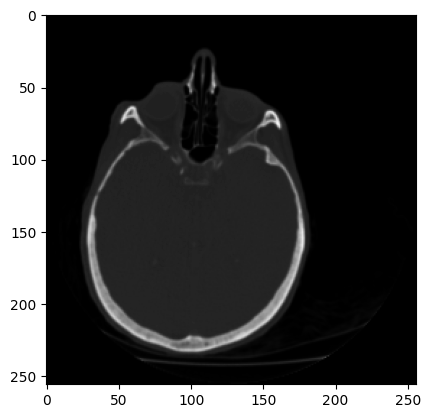

In [26]:
import matplotlib.pyplot as plt

plt.imshow(brain[9], cmap="gray")

In [8]:
qc = NEQR().image_quantum_circuit(image=resize(train_dataset.imgs[0], (2,2,2)))

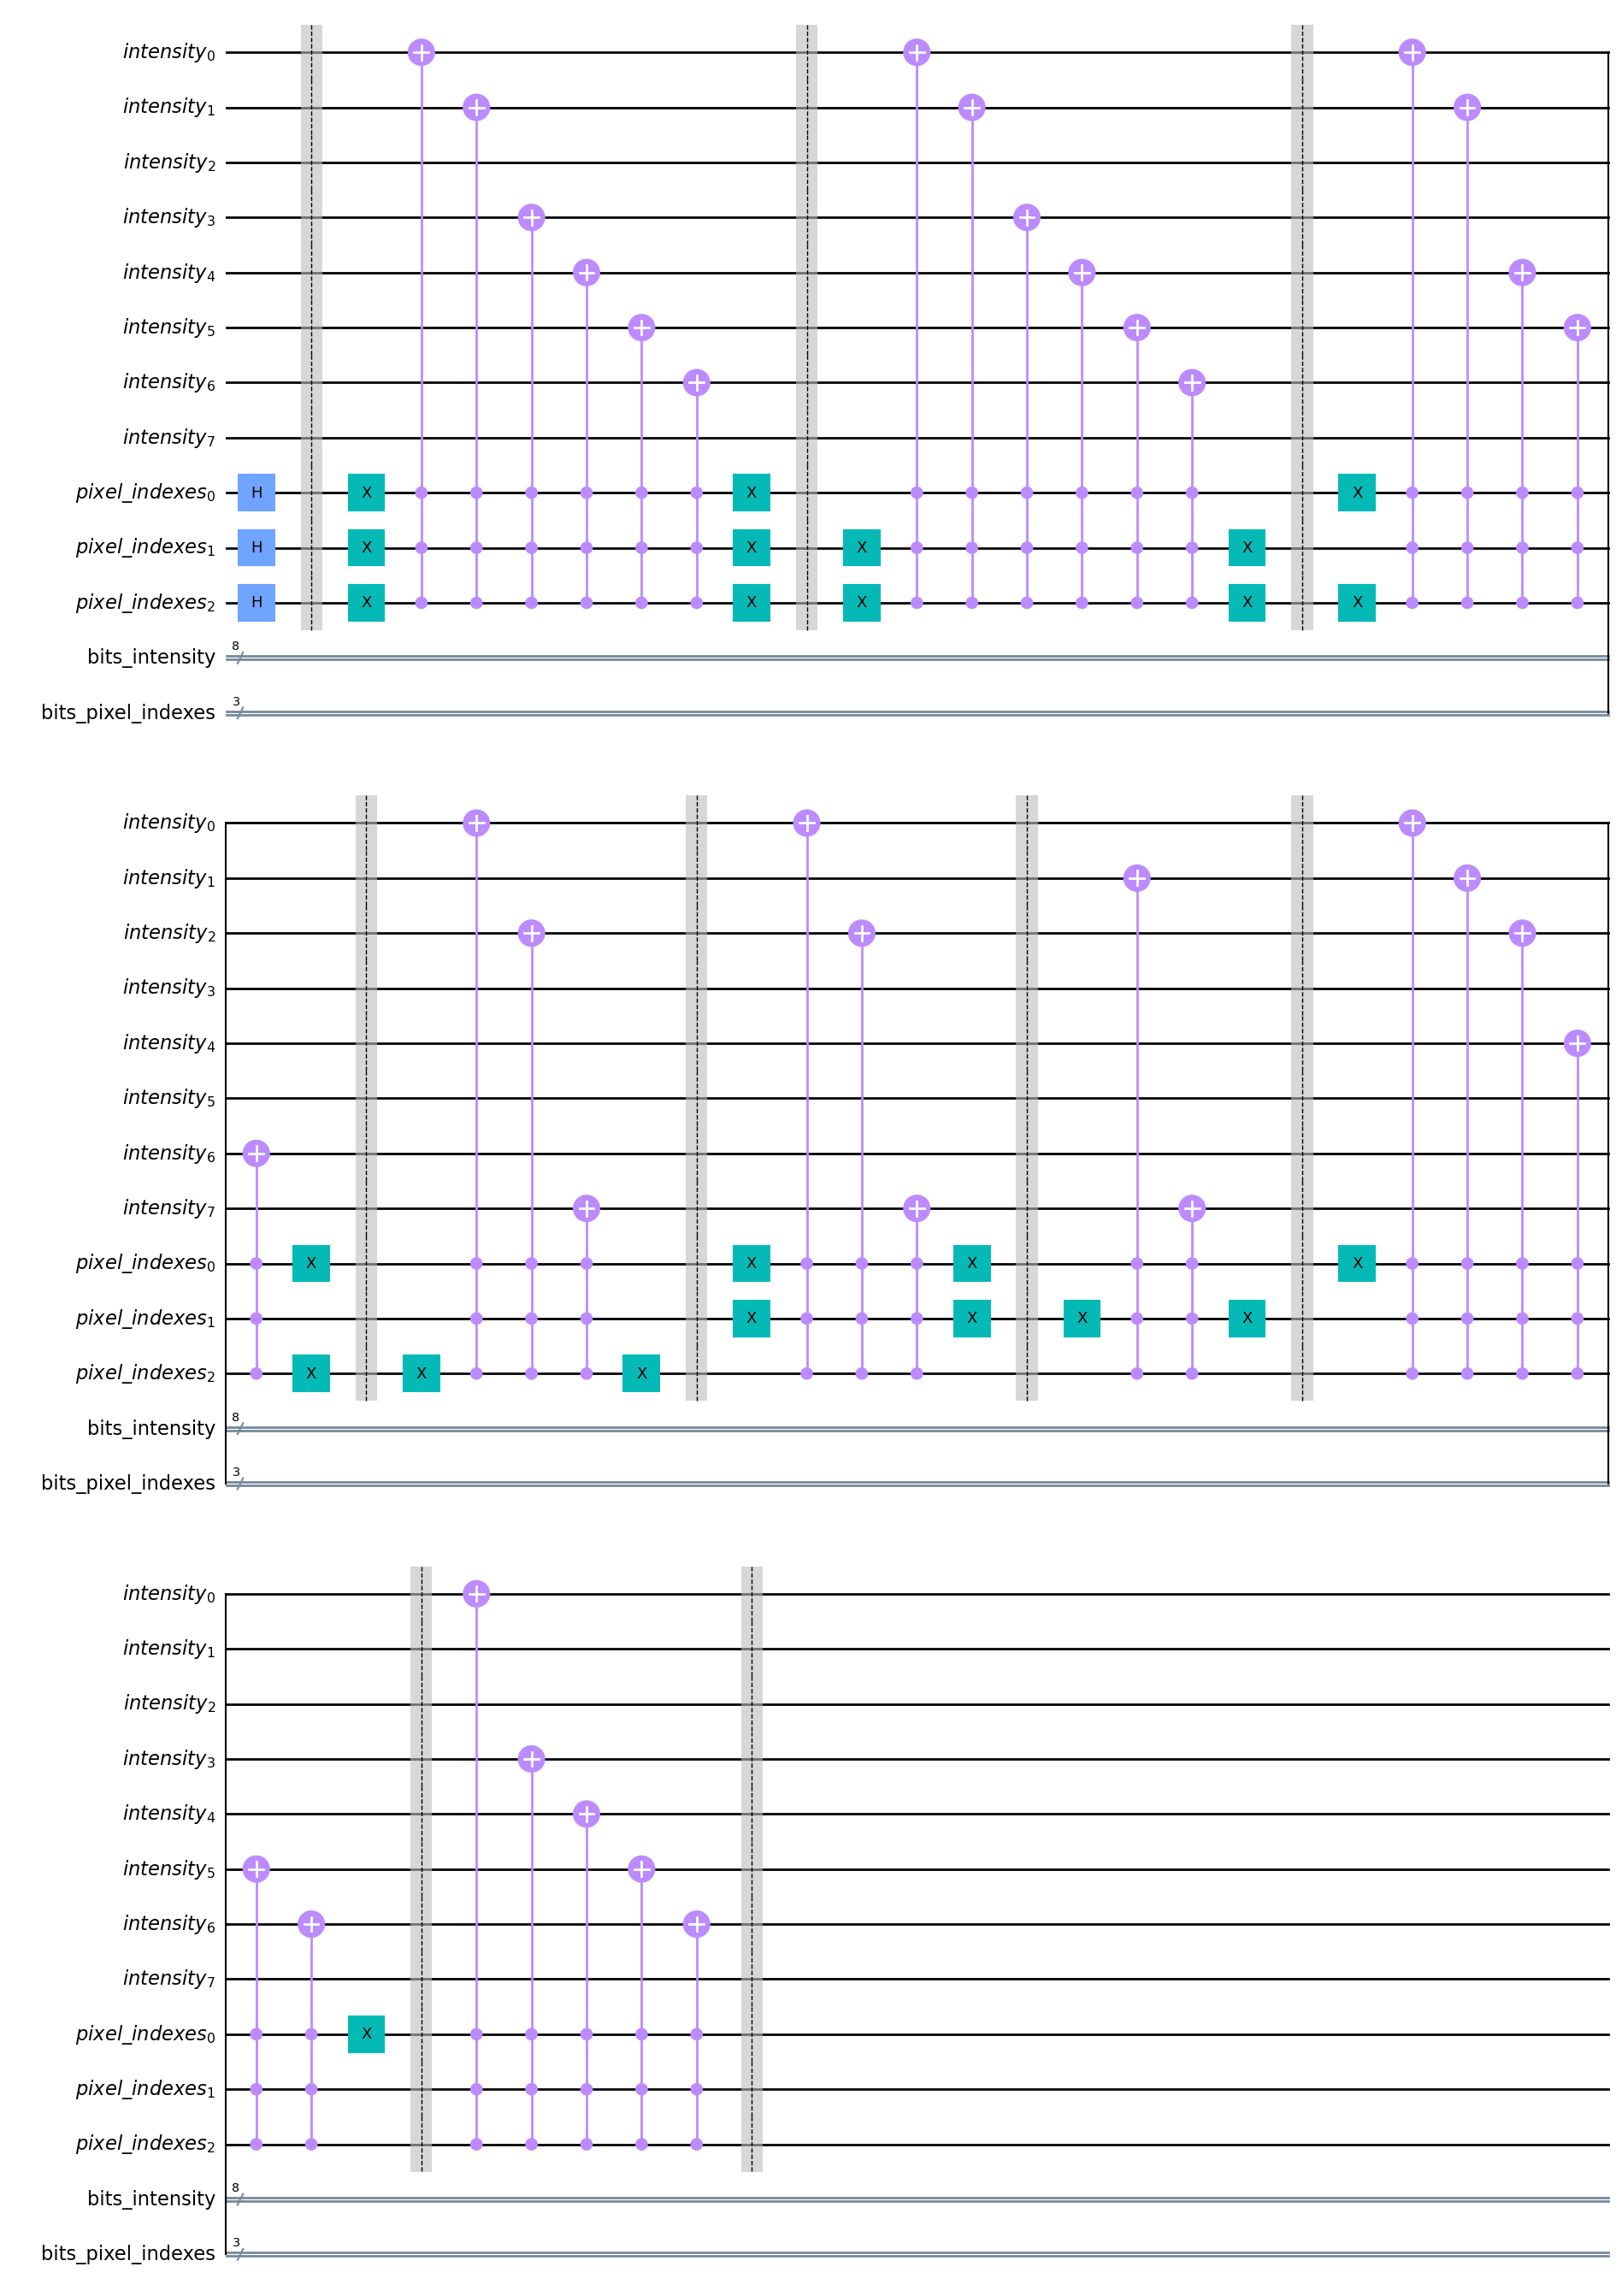

In [9]:
qc.draw("mpl")

In [8]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [9]:
def quantum_net(size_input_features=4, size_weights=4):
    """
    The variational quantum circuit.
    """

    qc = QuantumCircuit(n_qubits)
    
    qc.h(qubit=[i for i in range(n_qubits)])

    input_params = ParameterVector(name="input", length=size_input_features)
    for idx, param in enumerate(input_params):
        qc.ry(theta=param, qubit=idx)

    for k in range(q_depth):
        for i in range(0, n_qubits - 1, 2):
            qc.cx(control_qubit=i, target_qubit=i+1)
        for i in range(1, n_qubits - 1, 2):
            qc.cx(control_qubit=i, target_qubit=i+1)
        params = ParameterVector(name=f"q_weights_{k}", length=size_weights)
        for idx, param in enumerate(params):
            qc.ry(theta=param, qubit=idx)

    qnn = CircuitQNN(qc,
                      qc.parameters[:4],
                      qc.parameters[4:],
                      input_gradients=True,
                      quantum_instance=dev
    )
    
    return qnn

In [10]:
class HybridCNN(nn.Module):
    
    def __init__(self, qnn) -> None:
        
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 2, kernel_size=5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(2, 16, kernel_size=5),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        
        self.dropout = nn.Dropout2d()
        
        self.layer3 = nn.Sequential(nn.Linear(256, 64),
                                    nn.Linear(64, 2))
        
        self.qnn = TorchConnector(qnn)
        
        self.layer4 = nn.Sequential(
            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.qnn(x)
        x = self.layer4(x)
        
        return x

In [11]:
class HybridNet(nn.Module):
    
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = nn.Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)    

In [21]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qnn = TwoLayerQNN(2, 
                      feature_map=feature_map,
                      ansatz=ansatz,
                      input_gradients=True,
                      exp_val=AerPauliExpectation(),
                      quantum_instance=dev)
    return qnn

In [22]:
# qnn = quantum_net()
qnn = create_qnn()

In [23]:
model = HybridNet(qnn=qnn)

In [24]:
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [18:08<00:00, 29.42s/it]


In [26]:
def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

In [27]:
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.513  acc: 0.704
test  auc: 0.897  acc: 0.702
